## Preparation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob, os, sys
import numpy as np
import csv
import cv2

In [3]:
import pickle
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

In [4]:
import tensorflow as tf
import PIL
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.applications import mobilenet as _mobilenet
import numpy as np
from PIL import Image
import networkx as nx
from IPython.display import Image as iImage
from IPython.display import display
import math
import matplotlib.pyplot as plt
import ebooklib
from ebooklib import epub
import random
import re
import os
import nltk
from nltk.corpus import words
import gensim
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import words, stopwords, names
from sklearn.decomposition import PCA
import scipy.spatial
from matplotlib import cm
import matplotlib.image as mpimg
import pandas as pd
import jieba
from sklearn.metrics.pairwise import linear_kernel
from nltk import pos_tag
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import sklearn

In [5]:
from preprocessmodel import preprocessmodel

In [9]:
from preprocessmodel import preprocess

## Image Fuyu

In [15]:
def calculateQE(SOM,data):
    sumSqDist = 0
    for d in data:
        g,h = find_BMU1(SOM, d)
        v1 = SOM[g,h]
        v2 = d
        sumSqDist += scipy.spatial.distance.cdist([v1],[v2],'cosine')[0][0]
    QE = sumSqDist/len(data)
    return QE
def find_BMU_2(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argpartition(cos_sims, -2, axis=None)[-2], cos_sims.shape)
def calculateTE(SOM,data):
    failed = 0
    for d in data:
        g1,h1 = find_BMU1(SOM,d)
        g2,h2 = find_BMU_2(SOM,d)
        dist = scipy.spatial.distance.cityblock([g1,h1], [g2,h2])
        if dist>1:
            failed+=1
    return failed/len(data)
def normalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    normalised_p = (p-min_d)/(max_d - min_d)
    return normalised_p
def denormalise(train, p):
    min_d = np.min(train)
    max_d = np.max(train)
    denormalised_p = p * (max_d - min_d) + min_d
    return denormalised_p
def find_BMU1(SOM,x):
    somShape = SOM.shape
    simSOM = SOM.reshape((-1, len(x)))
    cos_sims = cosine_similarity([x], simSOM).reshape(somShape[:2])
    return np.unravel_index(np.argmax(cos_sims, axis=None), cos_sims.shape)

def update_weights(SOM, train_ex, learn_rate, radius_sq,
                   BMU_coord, step=3):
    g, h = BMU_coord
    #if radius is close to zero then only BMU is changed
    if radius_sq < 1e-3:
        SOM[g,h,:] += learn_rate * (train_ex - SOM[g,h,:])
        return SOM
    # Change all cells in a small neighborhood of BMU
    for i in range(max(0, g-step), min(SOM.shape[0], g+step)):
        for j in range(max(0, h-step), min(SOM.shape[1], h+step)):
            dist_sq = np.square(i - g) + np.square(j - h)
            dist_func = np.exp(-dist_sq / 2 / radius_sq)
            SOM[i,j,:] += learn_rate * dist_func * (train_ex - SOM[i,j,:])
    return SOM
def train_SOM(SOM, train_data, learn_rate = .1, radius_sq = 1,
             lr_decay = .1, radius_decay = .1, epochs = 10):
    learn_rate_0 = learn_rate
    radius_0 = radius_sq
    for epoch in np.arange(0, epochs):
        np.random.shuffle(train_data)
        for train_ex in train_data:
            g, h = find_BMU1(SOM, train_ex)
            SOM = update_weights(SOM, train_ex,
                                 learn_rate, radius_sq, (g,h))
        # Update learning rate and radius
        learn_rate = learn_rate_0 * np.exp(-epoch * lr_decay)
        radius_sq = radius_0 * np.exp(-epoch * radius_decay)
    return SOM
def cosine(a,b):
    return cosine_similarity([a], [b])[0][0]

def u_matrix(lattice):
    """Builds a U-matrix on top of the trained lattice.

        Parameters
        ---
        lattice : list

            The SOM generated lattice

        Returns
        ---
        The lattice of the shape (R,C):

        R - number of rows; C - number of columns;
        """
    X, Y, Z = lattice.shape
    u_values = np.empty((X,Y), dtype=np.float64)
    for y in range(Y):
        for x in range(X):
            current = lattice[x,y]
            dist = 0
            num_neigh = 0
            # left
            if x-1 >= 0:
                #middle
                vec = lattice[x-1,y]
                dist += cosine(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #sup
                    vec = lattice[x-1, y-1]
                    dist += cosine(current, vec)
                    num_neigh += 1
                if y + 1 < Y:
                    # down
                    vec = lattice[x-1,y+1]
                    dist += cosine(current, vec)
                    num_neigh += 1
            # middle
            if y - 1 >= 0:
                # up
                vec = lattice[x,y-1]
                dist += cosine(current, vec)
                num_neigh += 1
            # down
            if y + 1 < Y:
                vec = lattice[x,y+1]
                dist += cosine(current, vec)
                num_neigh += 1
            # right
            if x + 1 < X:
                # middle
                vec = lattice[x+1,y]
                dist += cosine(current, vec)
                num_neigh += 1
                if y - 1 >= 0:
                    #up
                    vec = lattice[x+1,y-1]
                    dist += cosine(current, vec)
                    num_neigh += 1
                if y + 1 < lattice.shape[1]:
                    # down
                    vec = lattice[x+1,y+1]
                    dist += cosine(current, vec)
                    num_neigh += 1
            u_values[x,y] = dist / num_neigh
    u_values = (u_values - 1) * -1
    return u_values
def activate1(train_data, SOM, p):
    normalP = normalise(train_data, p)
    activatedSOM = np.array([[cosine_similarity([normalP], [c])[0][0] for c in r] for r in SOM])
    normalisedActivatedSOM = normalise(activatedSOM, activatedSOM)
    #activatedSOM = (normalisedActivatedSOM -1)*(-1)
    return activatedSOM
def normalise_2(train):
    min_d = np.min(train, axis=0)
    max_d = np.max(train, axis=0)
    normalised_train = (train - min_d) / (max_d - min_d)
    return normalised_train
def find_closest_cos(data, v):
    cos_dist = cosine_similarity(data, [v])
    return np.argmax(cos_dist)

In [6]:
madrid_fuyu_text_list=[]
with open("Image_Textualisation.csv", 'r',encoding='utf-8') as file:
    csvreader = csv.reader(file)
    for i in csvreader:
        madrid_fuyu_text_list.append(i[1])

In [7]:
clear_madrid_fuyu_text_list=[]
for i in madrid_fuyu_text_list:
    if i not in clear_madrid_fuyu_text_list:
        clear_madrid_fuyu_text_list.append(i)

In [10]:
preprocessed_madrid_fuyu_text_list=preprocess(clear_madrid_fuyu_text_list)

In [11]:
madrid_sentences=preprocessed_madrid_fuyu_text_list
tagged_data = [TaggedDocument(words=madrid_sentence.split(), tags=[str(i)]) for i, madrid_sentence in enumerate(madrid_sentences)]
model2 = Doc2Vec(vector_size=300, min_count=1, epochs=10)
model2.build_vocab(tagged_data)
model2.train(tagged_data, total_examples=model2.corpus_count, epochs=model2.epochs)
madrid_sentence_vectors = [model2.infer_vector(madrid_sentence.split()) for madrid_sentence in madrid_sentences]
#u_matrix = np.array(sentence_vectors)

In [12]:
with open('madrid_sentence_vectors.pkl', 'wb') as f:
    pickle.dump(madrid_sentence_vectors, f)

In [13]:
with open('madrid_sentence_vectors.pkl', 'rb') as f:
    madrid_sentence_vectors = pickle.load(f)

Epoch: 1, QE: 0.097, TE: 0.2061


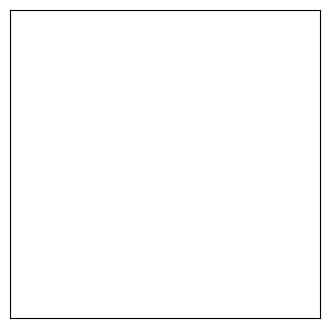

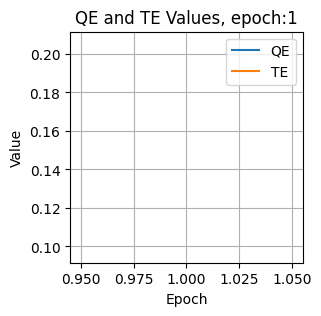

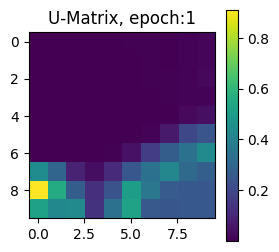

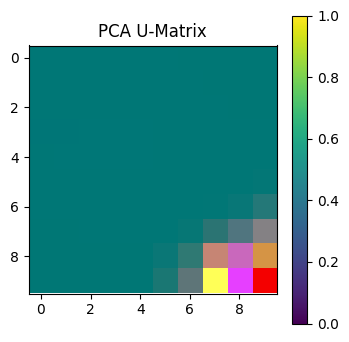

Epoch: 2, QE: 0.0702, TE: 0.1758


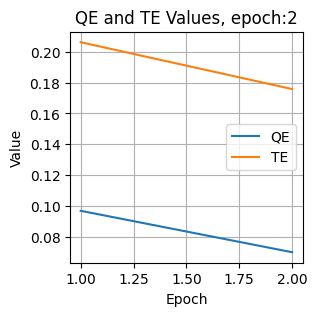

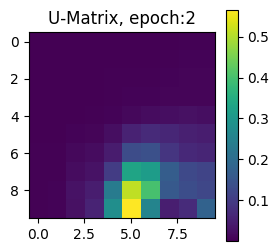

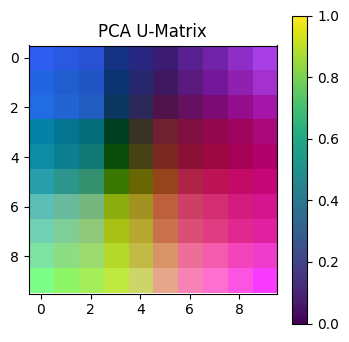

Epoch: 3, QE: 0.0638, TE: 0.1747


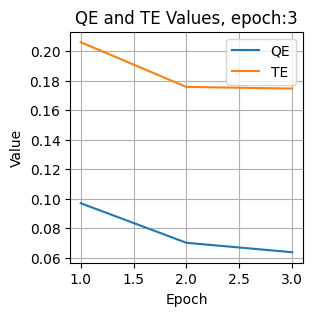

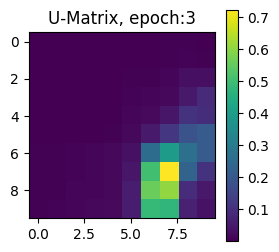

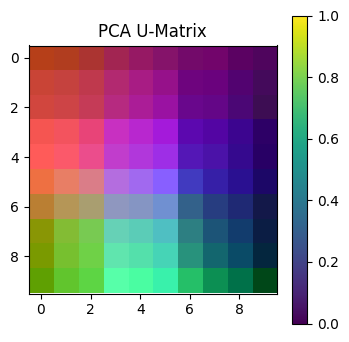

Epoch: 4, QE: 0.0622, TE: 0.2152


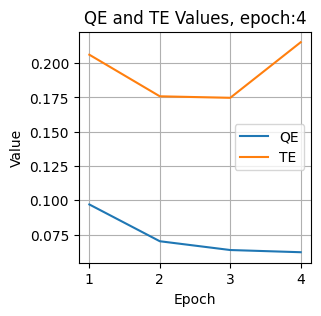

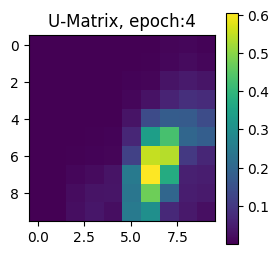

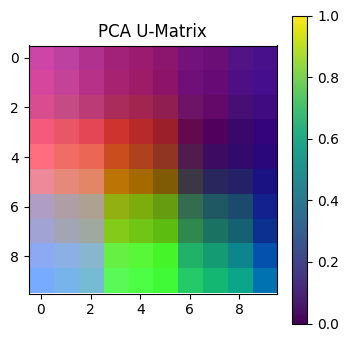

Epoch: 5, QE: 0.0633, TE: 0.1798


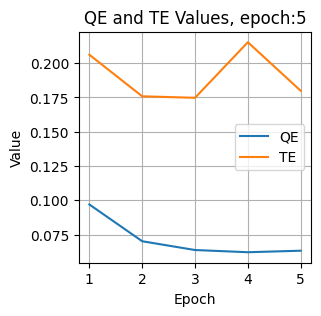

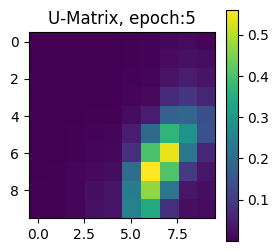

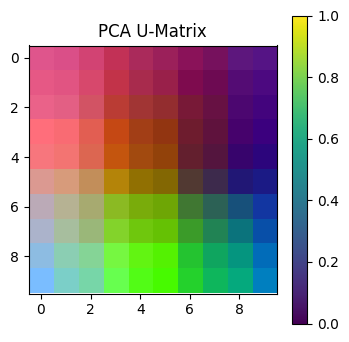

Epoch: 6, QE: 0.0635, TE: 0.1717


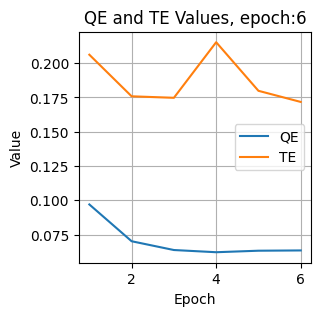

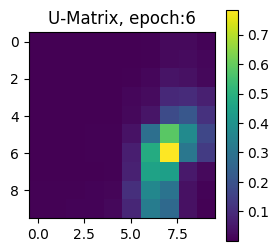

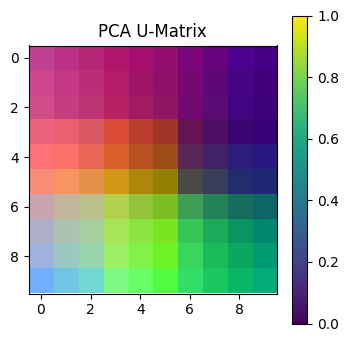

Epoch: 7, QE: 0.0616, TE: 0.1848


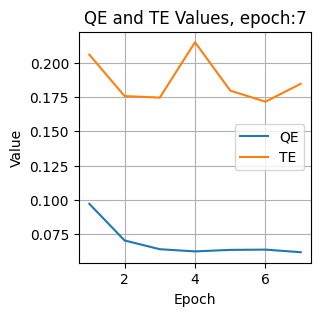

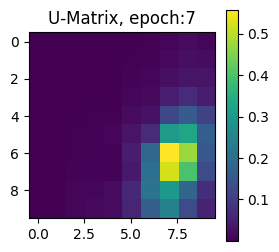

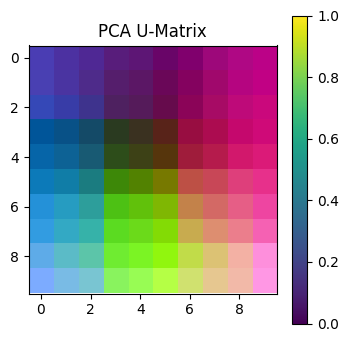

Epoch: 8, QE: 0.0627, TE: 0.1404


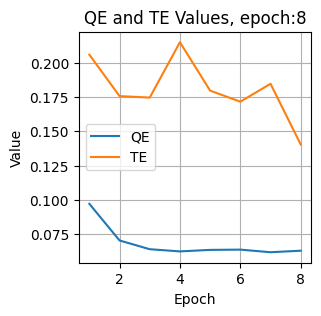

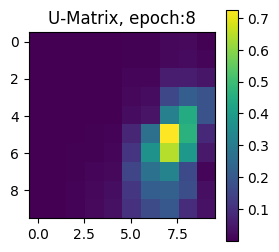

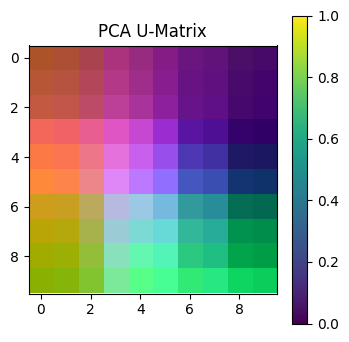

Epoch: 9, QE: 0.0626, TE: 0.1535


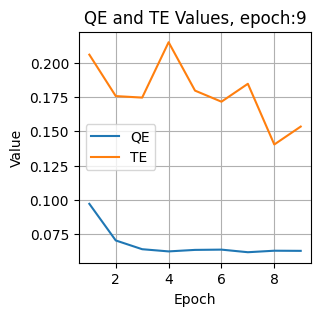

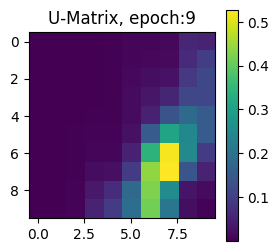

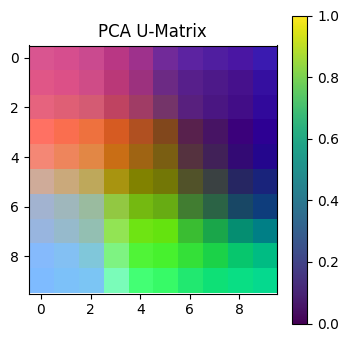

Epoch: 10, QE: 0.0608, TE: 0.2283


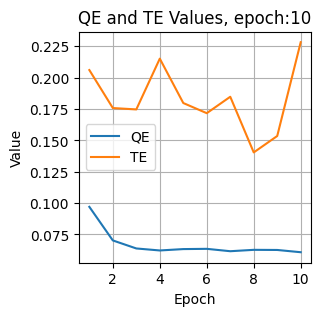

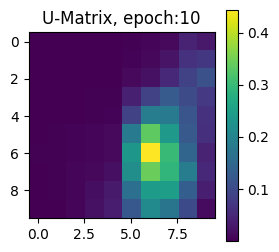

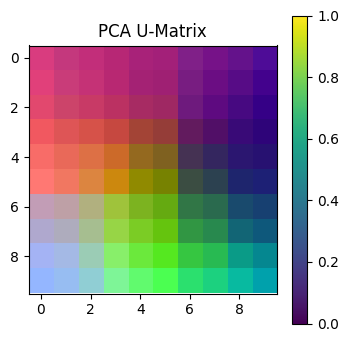

Epoch: 11, QE: 0.064, TE: 0.1758


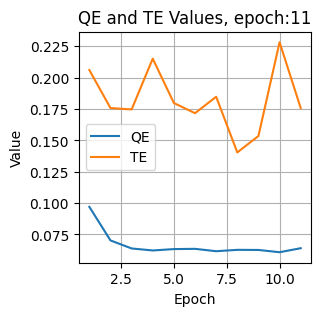

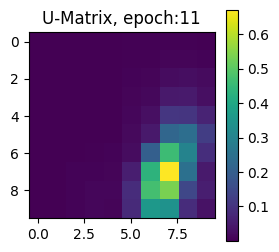

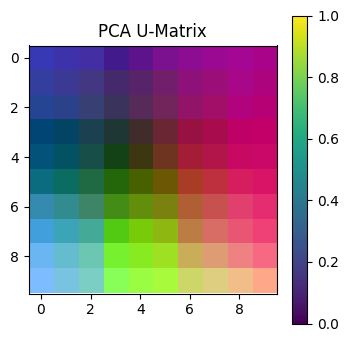

Epoch: 12, QE: 0.0631, TE: 0.1182


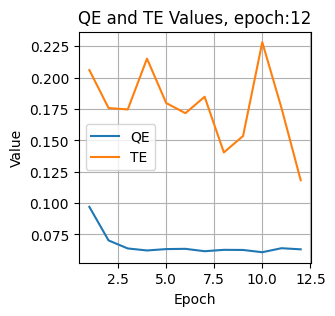

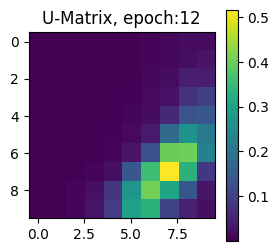

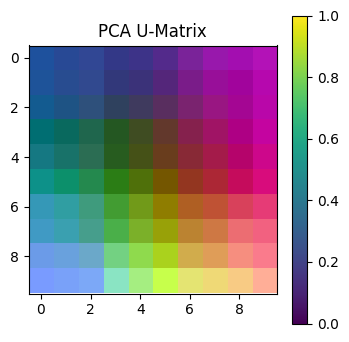

Epoch: 13, QE: 0.0668, TE: 0.1657


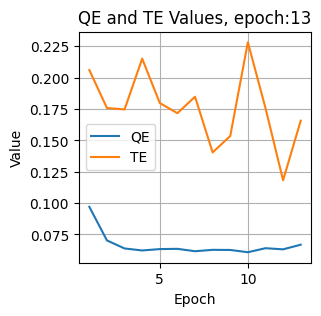

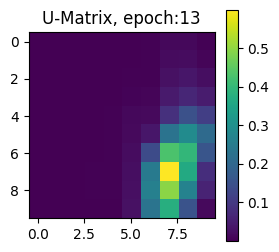

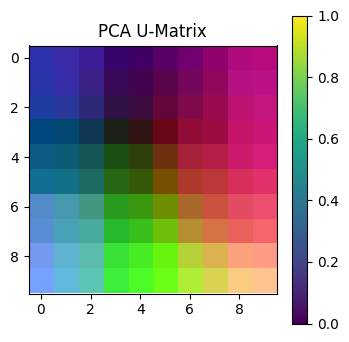

Epoch: 14, QE: 0.0622, TE: 0.2152


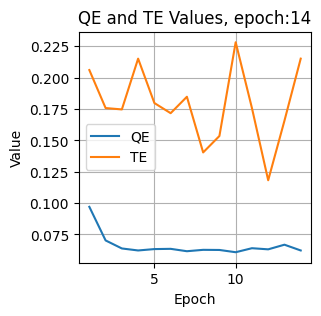

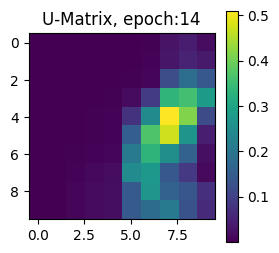

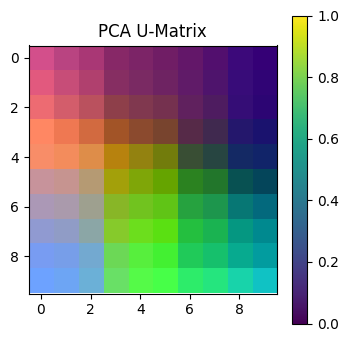

Epoch: 15, QE: 0.0606, TE: 0.2232


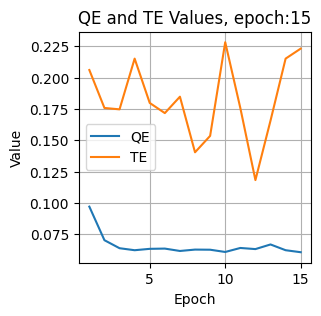

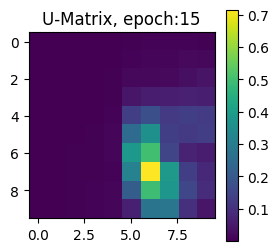

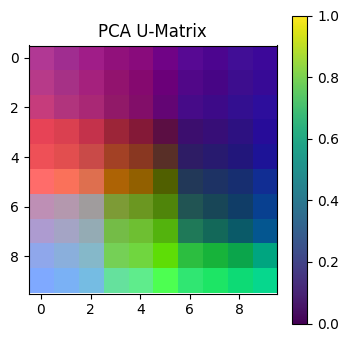

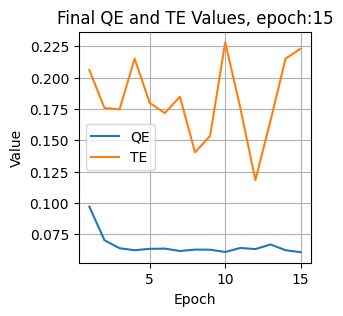

In [17]:
def plot_som_pca(SOM):
    # Reshape the SOM grid into a 2D array
    som_flat = SOM.reshape(-1, SOM.shape[-1])

    # Perform PCA with 3 components
    pca = PCA(n_components=3)
    som_pca = pca.fit_transform(som_flat)

    # Normalize PCA components to [0, 1]
    som_pca_norm = (som_pca - som_pca.min(axis=0)) / (som_pca.max(axis=0) - som_pca.min(axis=0))

    # Create a U-matrix with PCA components as RGB values
    u_matrix_pca = som_pca_norm.reshape(SOM.shape[:-1] + (3,))

    # Plot the U-matrix with PCA colors
    plt.figure(figsize=(4, 4))
    plt.imshow(u_matrix_pca)
    plt.title('PCA U-Matrix')
    plt.colorbar()
    plt.show()

# Initialize SOM grid dimensions
m = 10
n = 10

# Initialize training data
train_data = madrid_sentence_vectors

# Initialize SOM grid with random weights
SOM = np.random.rand(m, n, train_data[0].shape[0])

epochs = 100
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(4, 4),
    subplot_kw=dict(xticks=[], yticks=[]))
total_epochs = 0
SOMS = []
QE_values = []
TE_values = []
epoch_numbers = []

# Convert train_data to numpy array
train_data_array = np.array(train_data)

# Training loop
for epochs_per_iter, i in zip([15], range(1)):
    total_epochs += epochs_per_iter

    # Train the SOM for the specified number of epochs_per_iter
    for epoch in range(1, epochs_per_iter + 1):
        SOM = train_SOM(SOM, train_data_array, learn_rate=0.1, radius_sq=12, epochs=1)  # Train for 1 epoch

        # Calculate QE and TE
        QE = round(calculateQE(SOM, train_data_array), 4)
        TE = round(calculateTE(SOM, train_data_array), 4)

        # Print epoch number and QE, TE values
        print(f"Epoch: {total_epochs - epochs_per_iter + epoch}, QE: {QE}, TE: {TE}")

        # Save QE and TE values
        QE_values.append(QE)
        TE_values.append(TE)
        epoch_numbers.append(total_epochs - epochs_per_iter + epoch)

        # Save a copy of SOM at this epoch
        SOMS.append(SOM.copy())

        # Plot QE and TE values after each epoch
        plt.figure(figsize=(3, 3))
        plt.plot(epoch_numbers, QE_values, label='QE')
        plt.plot(epoch_numbers, TE_values, label='TE')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('QE and TE Values, epoch:'+str(epoch))
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot the u_matrix after each epoch
        plt.figure(figsize=(3, 3))
        plt.imshow(u_matrix(SOM))
        plt.title('U-Matrix, epoch:'+str(epoch))
        plt.colorbar()
        plt.show()

        # Plot the SOM based on PCA
        plot_som_pca(SOM)

    # Plot the final state of the SOM grid after the last epoch
    if epoch == epochs_per_iter:
        plt.figure(figsize=(3, 3))
        plt.plot(epoch_numbers, QE_values, label='QE')
        plt.plot(epoch_numbers, TE_values, label='TE')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.title('Final QE and TE Values, epoch:'+str(epoch))
        plt.legend()
        plt.grid(True)
        plt.show()

    ax.imshow(u_matrix(SOM))
    ax.title.set_text('Epochs = ' + str(total_epochs) + '\n QE =' + str(QE) + ' TE =' + str(TE))

# Show the final plot
plt.show()

In [18]:
SOM= SOMS[11]

In [19]:
QE = QE_values[11]
TE = TE_values[11]

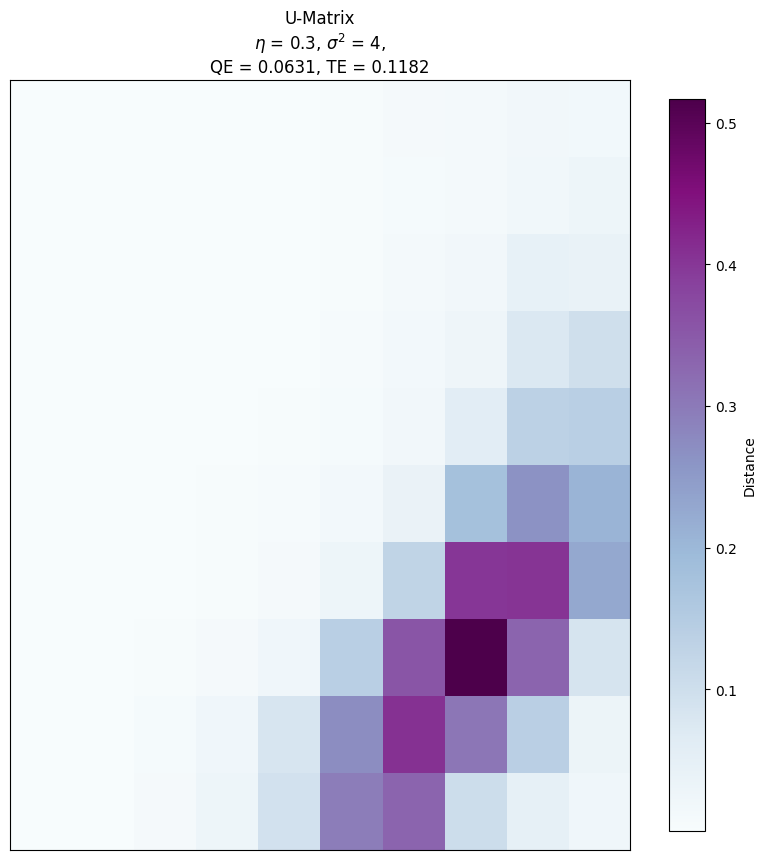

In [20]:
u_matrix_values = u_matrix(SOM)

plt.figure(figsize=(10, 10))
im = plt.imshow(u_matrix_values, cmap=cm.BuPu, aspect='auto')
plt.title(f'U-Matrix\n$\eta$ = {0.3}, $\sigma^2$ = {4},\nQE = {QE}, TE = {TE}')
plt.colorbar(im, shrink=0.95, label='Distance')
plt.xticks([])
plt.yticks([])
plt.show()

In [22]:
madrid_fuyu_som_model = SOMS[11]

In [23]:
with open('madrid_fuyu_som_model.pkl', 'wb') as f:
    pickle.dump(madrid_fuyu_som_model, f)

In [24]:
with open('madrid_fuyu_som_model.pkl', 'rb') as f:
    loaded_madrid_fuyu_som_model = pickle.load(f)

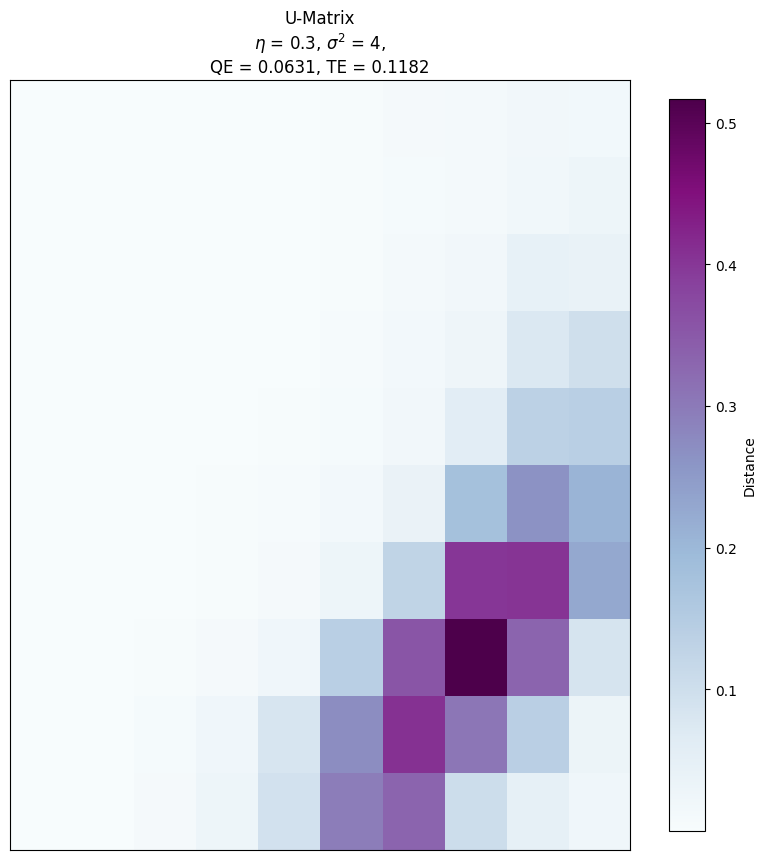

In [25]:
u_matrix_values = u_matrix(loaded_madrid_fuyu_som_model)
QE = round(calculateQE(loaded_madrid_fuyu_som_model, madrid_sentence_vectors), 4)
TE = round(calculateTE(loaded_madrid_fuyu_som_model, madrid_sentence_vectors), 4)

plt.figure(figsize=(10, 10))
im = plt.imshow(u_matrix_values, cmap=cm.BuPu, aspect='auto')
plt.title(f'U-Matrix\n$\eta$ = {0.3}, $\sigma^2$ = {4},\nQE = {QE}, TE = {TE}')
plt.colorbar(im, shrink=0.95, label='Distance')
plt.xticks([])
plt.yticks([])
plt.show()

In [26]:
madrid_fuyu_dict = []
for i in range(len(loaded_madrid_fuyu_som_model)):
    row = []
    for j in range(len(loaded_madrid_fuyu_som_model[0])):
        row.append([])
    madrid_fuyu_dict.append(row)
madridvectortextPairs=[]
for i in range(0,len(clear_madrid_fuyu_text_list)):
    madridvectortext={}
    madridvectortext['text']=clear_madrid_fuyu_text_list[i]
    madridvectortext['vector']=madrid_sentence_vectors[i]
    madridvectortextPairs.append(madridvectortext)
for i in madridvectortextPairs:
    g,h = find_BMU1(loaded_madrid_fuyu_som_model,i['vector'])
    madrid_fuyu_dict[g][h].append(i)

In [28]:
with open('madrid_fuyu_dict.pkl', 'wb') as f:
    pickle.dump(madrid_fuyu_dict, f)

In [29]:
with open('madrid_fuyu_dict.pkl', 'rb') as f:
    madrid_fuyu_dict = pickle.load(f)

### Defining Search Function

In [32]:
def searchmadridfuyusom(query):
    result=[]
    query=[query]
    preprocessed_query=preprocess(query)
    query_vector = model2.infer_vector(preprocessed_query[0].split())
    activatedSOM = activate1(madrid_sentence_vectors, loaded_madrid_fuyu_som_model, query_vector)
    fig = plt.figure()
    plt.figure(figsize=(10, 10))
    im = plt.imshow(activatedSOM, cmap=cm.BuPu, aspect='auto')
    plt.title(f'U-Matrix\n$\eta$ = {0.3}, $\sigma^2$ = {4},\nQE = {QE}, TE = {TE}')
    plt.colorbar(im, shrink=0.95, label='Distance')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    similarities = {}
    for i in madrid_fuyu_dict[g][h]:
        vector_array = np.array([i['vector']])
        vector_array = vector_array.reshape(1, -1) 
        similarities[i['text']] = cosine_similarity(vector_array, [loaded_madrid_fuyu_som_model[g][h]])
    biggest = None
    max_similarity = similarities[madrid_fuyu_dict[g][h][0]['text']]
    for i in madrid_fuyu_dict[g][h]:
        sim = similarities[i['text']]
        if sim > max_similarity:
            max_similarity = sim
            biggest = i['text']
    result.append(biggest)
    return result

<Figure size 640x480 with 0 Axes>

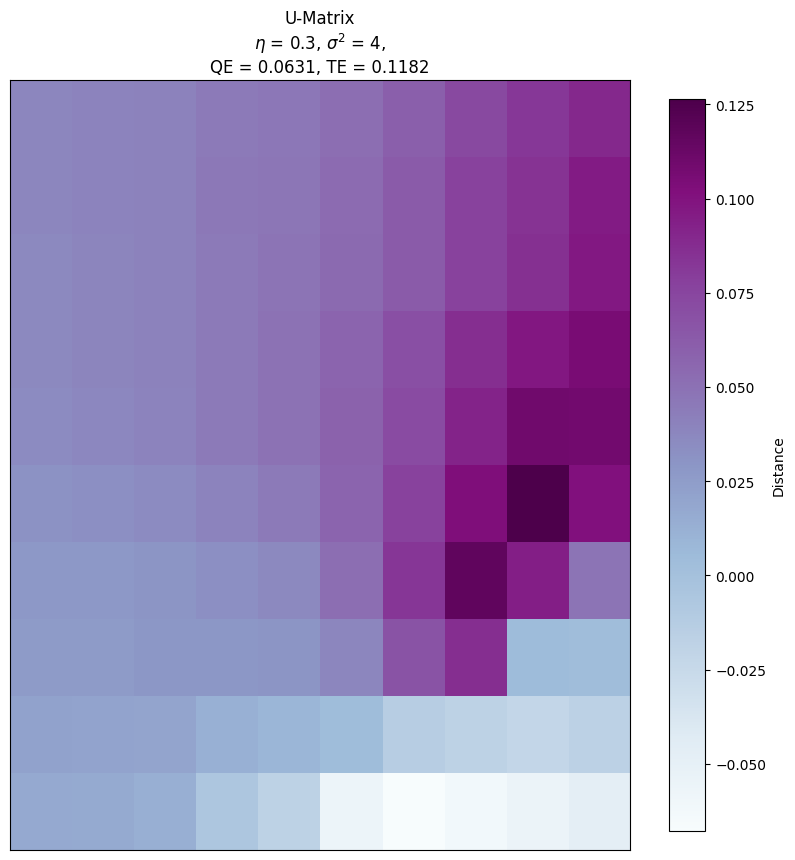

['In the image, there is a large crowd of people walking down a street, with some of them wearing face masks. Among them, a woman is wearing a pink scarf and a black shirt. The crowd is spread out along the street, with some standing closer to the camera and others farther away.\n\nIn the background, there are multiple stalls with items for sale,']

In [33]:
searchmadridfuyusom('A parliament of counter-culture.')